In [1]:
from googlesearch import search
import requests
from bs4 import BeautifulSoup
import pandas as pd
import matplotlib.pyplot as plt
from wordcloud import WordCloud
from selenium import webdriver
from selenium.webdriver.chrome.options import Options
from webdriver_manager.chrome import ChromeDriverManager
import seaborn as sns
import dateparser
import time
import re

In [2]:
def collect_urls(query: str, max_results: int=98):
    q = f"{query} site:vlast.kz"
    results = list(search(q, num_results=max_results))
    urls = [u for u in results if "vlast.kz" in u]
    return urls[:max_results]

urls = collect_urls("Фонд Булата Утемуратова", max_results=98)
len(urls)

97

In [3]:
options = Options()
options.add_argument("--headless")
options.add_argument("--disable-gpu")
options.add_argument("--no-sandbox")
options.add_argument("start-maximized")
options.add_argument("user-agent=Mozilla/5.0 (Macintosh; Intel Mac OS X 10_15_7) "
                     "AppleWebKit/537.36 (KHTML, like Gecko) "
                     "Chrome/114.0.0.0 Safari/537.36")

from selenium.webdriver.chrome.service import Service

service = Service(ChromeDriverManager().install())
driver  = webdriver.Chrome(service=service, options=options)

In [4]:
def parse_article_selenium(url: str):
    if not url.lower().startswith(("http://", "https://")):
        url = "https://" + url

    try:
        driver.get(url)
    except Exception as e:
        print(f"Error loading {url!r}: {e}")
        return {"url": url, "title": None, "date": None, "comments": 0, "views": 0}

    time.sleep(2)
    soup = BeautifulSoup(driver.page_source, "html.parser")

    title_el = soup.select_one("h1")
    title    = title_el.get_text(strip=True) if title_el else None

    date_el  = soup.select_one("ul.meta.item-expand-meta.time-uppercase.list-inline time.news-date.js-date-long")
    if not date_el:
        date_el = soup.select_one("ul.meta.item-expand-meta time.news-date.js-date-long")
    date_txt = date_el.get_text(strip=True) if date_el else None

    views_li  = soup.select_one("ul.meta.item-expand-meta li:has(.icon--view-gray)")
    views_txt = views_li.get_text(strip=True) if views_li else ""
    views     = int(re.sub(r"\D", "", views_txt)) if views_txt else 0

    return {
        "url":      url,
        "title":    title,
        "date":     date_txt,
        "views":    views
    }

In [5]:
urls = collect_urls("Фонд Булата Утемуратова", max_results=98)
data = [parse_article_selenium(u) for u in urls]
df = pd.DataFrame(data)
df.head(5)

Error loading 'https:///search?q=%D0%A4%D0%BE%D0%BD%D0%B4+%D0%91%D1%83%D0%BB%D0%B0%D1%82%D0%B0+%D0%A3%D1%82%D0%B5%D0%BC%D1%83%D1%80%D0%B0%D1%82%D0%BE%D0%B2%D0%B0+site:vlast.kz&num=100&safe=active&sca_esv=69251213fe4ae3f6&hl=en&ie=UTF-8&filter=0': Message: unknown error: net::ERR_NAME_NOT_RESOLVED
  (Session info: chrome=136.0.7103.114)
Stacktrace:
0   chromedriver                        0x00000001055043cc cxxbridge1$str$ptr + 2829900
1   chromedriver                        0x00000001054fc694 cxxbridge1$str$ptr + 2797844
2   chromedriver                        0x0000000105039fbc cxxbridge1$string$len + 90140
3   chromedriver                        0x00000001050325ac cxxbridge1$string$len + 58892
4   chromedriver                        0x000000010502521c cxxbridge1$string$len + 4732
5   chromedriver                        0x0000000105026c10 cxxbridge1$string$len + 11376
6   chromedriver                        0x0000000105025684 cxxbridge1$string$len + 5860
7   chromedriver               

,url,title,date,views,comments
0,https://vlast.kz/novosti/36345-bolee-6-mlrd-te...,Более 6 млрд тенге выделил фонд Булата Утемура...,"11.12.2019, 11:27",3722,NaN
1,https://vlast.kz/novosti/39415-fond-bulata-ute...,Фонд Булата Утемуратова выделит $6 млн на стро...,"08.05.2020, 11:49",5934,NaN
2,https://vlast.kz/novosti/38574-fond-bulata-ute...,Фонд Булата Утемуратова закупил 94 тысячи тест...,"06.04.2020, 11:40",3642,NaN
3,https://vlast.kz/novosti/60728-bolee-250-mlrd-...,Более 250 млрд тенге направили казахстанский б...,"25.06.2024, 11:46",2924,NaN
4,https://vlast.kz/novosti/samruk_qazyna_i_bulat...,«Самрук-Қазына» и Булат Утемуратов достигли «н...,"10.10.2013, 20:43",3849,NaN


In [6]:
df.to_csv("vlast_articles.csv", index=False)
print("Saved to vlast_articles.csv")

Saved to vlast_articles.csv


In [7]:
import dateparser
import pandas as pd

def parse_ru_date(x):
    if isinstance(x, str):
        return dateparser.parse(x, languages=['ru'])
    return pd.NaT

df['date'] = df['date'].apply(parse_ru_date)
df['date'] = pd.to_datetime(df['date'], errors='coerce')
df['views'] = pd.to_numeric(df['views'], errors='coerce').fillna(0).astype(int)

df.dtypes

/var/folders/3m/ygq196c16zs4wgq2yzkj4m200000gn/T/ipykernel_13540/88715954.py:6: DeprecationWarning: Parsing dates involving a day of month without a year specified is ambiguious
and fails to parse leap day. The default behavior will change in Python 3.15
to either always raise an exception or to use a different default year (TBD).
To avoid trouble, add a specific year to the input & format.
See https://github.com/python/cpython/issues/70647.
  return dateparser.parse(x, languages=['ru'])


url                 object
title               object
date        datetime64[ns]
views                int64
comments           float64
dtype: object

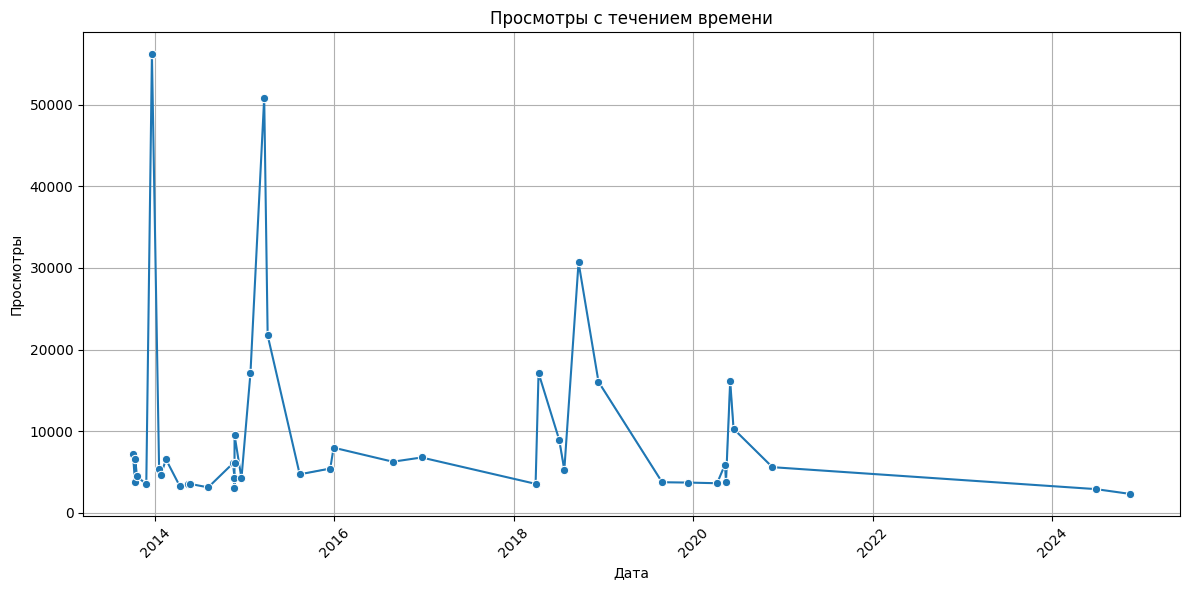

In [8]:
df_sorted = df.sort_values("date")

plt.figure(figsize=(12, 6))
sns.lineplot(data=df_sorted, x="date", y="views", marker="o")
plt.grid(True)
plt.title("Просмотры с течением времени")
plt.xlabel("Дата")
plt.ylabel("Просмотры")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

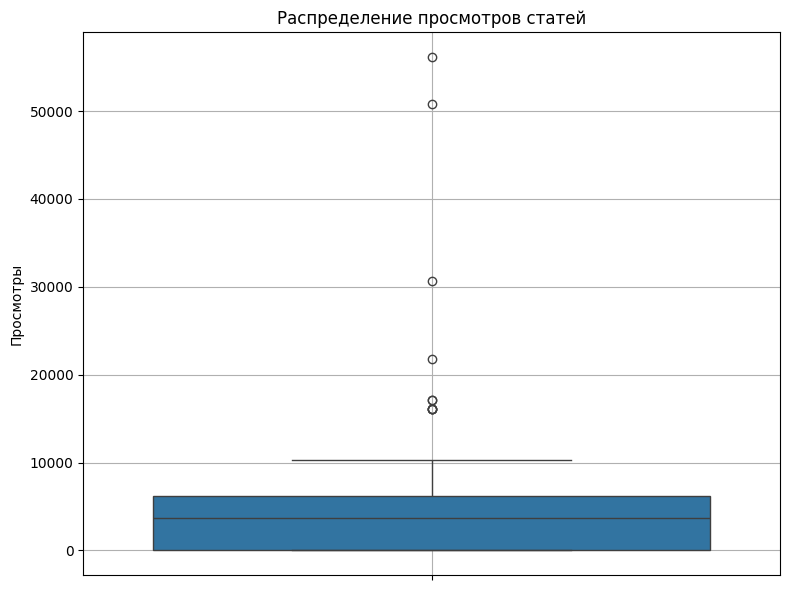

In [9]:
plt.figure(figsize=(8, 6))
sns.boxplot(y=df['views'])
plt.title("Распределение просмотров статей")
plt.ylabel("Просмотры")
plt.tight_layout()
plt.grid(True)
plt.show()

In [10]:
pd.set_option('display.max_colwidth', None)
Q1    = df['views'].quantile(0.25)
Q3    = df['views'].quantile(0.75)
IQR   = Q3 - Q1
lower = Q1 - 1.5 * IQR
upper = Q3 + 1.5 * IQR

outliers = df[(df['views'] < lower) | (df['views'] > upper)]
print(f"Number of outliers:{len(outliers)}")
outliers[['title','views']]

Number of outliers:10


,title,views
5,Республиканский музыкальный конкурс и стипендия имени Батырхана Шукенова появятся в Казахстане,17137
8,Благотворительность в Казахстане: почему заниматься ей все еще не просто?,30678
9,Аутизм. Победим,21743
18,Определены победители конкурса исполнителей имени Батырхана Шукенова,16060
33,Ботанический сад Алматы будет открыт для посещения с 15 июня,16147
54,"Тимур Исатаев, глава Альянс банка: «Купить банковский продукт должно быть также легко, как песенку в Itunes»",17119
64,10 исчезнувших банковских брендов Казахстана,50843
65,5 лиц недели: от священнослужителя до спонсора сирийских боевиков,56155
78,Определены победители конкурса исполнителей имени Батырхана Шукенова,16061
94,Ботанический сад Алматы будет открыт для посещения с 15 июня,16148


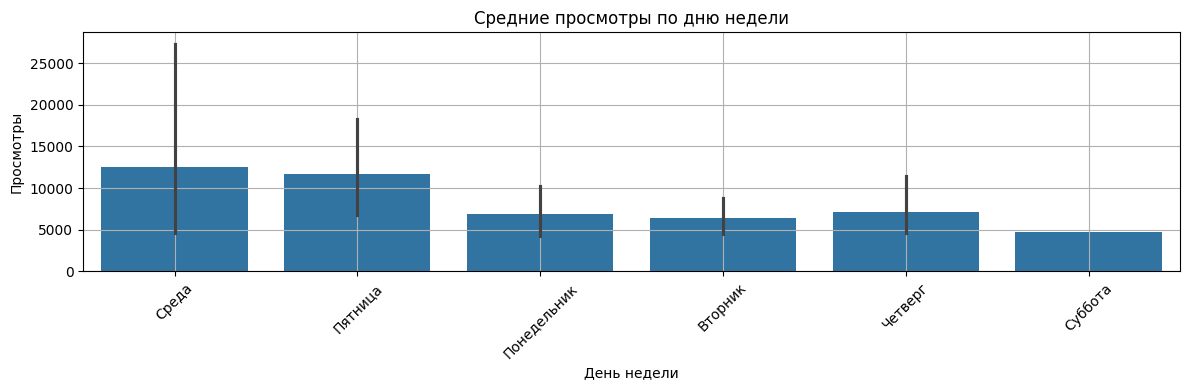

In [11]:
df['dow'] = df['date'].dt.day_name(locale='ru_RU')

plt.figure(figsize=(12, 4))
sns.barplot(
    data=df,
    x='dow',
    y='views',
    estimator='mean', 
)
plt.title("Средние просмотры по дню недели")
plt.xlabel("День недели")
plt.ylabel("Просмотры")
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.show()